In [28]:
INPUT_TRAINING_FOLDER = "./Inputs/Images/Training/"
INPUT_TESTING_FOLDER = "./Inputs/Images/Testing/"

MASKS_TRAINING_FOLDER = "./Masks_512x512/Training/"
MASKS_TESTING_FOLDER = "./Masks_512x512/Testing/"

PREDICT_FOLDER = "./Predicts/"

IMAGE_SIZE = (512, 512)

In [29]:
# Prepare images
from images_prepare import optimized_pre_images
X, X_sizes = optimized_pre_images(IMAGE_SIZE, INPUT_TRAINING_FOLDER)

In [30]:
# Mask prepare
Y, Y_sizes = optimized_pre_images(IMAGE_SIZE, path=MASKS_TRAINING_FOLDER) #Custom MASKS size IMG_SIZE

In [31]:
# Kiểm tra size hình X, Y
print(X.shape, X.dtype, type(X))
print(Y.shape, Y.dtype, type(Y))

(108, 512, 512, 1) uint8 <class 'numpy.ndarray'>
(108, 512, 512, 1) uint8 <class 'numpy.ndarray'>


In [32]:

# Chuyển giá trị kênh màu từ 0-255 về 0-1
import numpy as np

X = np.float32(X/255)
Y = np.float32(Y/255)


In [33]:
# Kiểm tra lại kiểu dữ liệu X, Y
print(X.shape, X.dtype, type(X))
print(Y.shape, Y.dtype, type(Y))

(108, 512, 512, 1) float32 <class 'numpy.ndarray'>
(108, 512, 512, 1) float32 <class 'numpy.ndarray'>


In [34]:
# Đổi tên biến thành x_train, y_train để xài cho khúc dưới
x_train = X.copy()
y_train = Y.copy()

In [35]:
# Load dữ liệu dùng để test và kết quả mong muốn cua nó
# Xử lý chuyển các kênh màu về 0-1 tương tự ở trên
x_test, x_test_sizes = optimized_pre_images(IMAGE_SIZE, INPUT_TESTING_FOLDER)
y_test_expected, y_test_expected_sizes = optimized_pre_images(IMAGE_SIZE, MASKS_TESTING_FOLDER)

x_test = np.float32(x_test / 255)
y_test_expected = np.float32(y_test_expected / 255)

print(x_test.shape, x_test.dtype, type(x_test))
print(y_test_expected.shape, y_test_expected.dtype, type(y_test_expected))

(6, 512, 512, 1) float32 <class 'numpy.ndarray'>
(6, 512, 512, 1) float32 <class 'numpy.ndarray'>


In [36]:
# Sinh thêm ảnh để train từ bộ x_train, y_train
import cv2
import albumentations as A

# Cấu hình sinh ảnh như thế nào?
img_generator = A.Compose([
    A.RandomBrightnessContrast(brightness_limit=0.25, contrast_limit=0.25, p=0.5),
    A.ShiftScaleRotate(shift_limit=0.325, scale_limit=0.15, rotate_limit=15, border_mode=cv2.BORDER_CONSTANT, p=1),
    A.Rotate(15, p=0.5),
    A.Blur(blur_limit=1, p=0.5),
    A.Downscale(scale_min=0.15, scale_max=0.25, always_apply=False, p=0.5),
    A.GaussNoise(var_limit=(0.05, 0.1), mean=0,
                 per_channel=True, always_apply=False, p=0.5),
    A.HorizontalFlip(p=0.25),
])

"""
Cách sử dụng img_generator:

img_gen = img_generator(image=..., mask=...)
x = img_gen['image']
y = img_gen['mask']
"""


"\nCách sử dụng img_generator:\n\nimg_gen = img_generator(image=..., mask=...)\nx = img_gen['image']\ny = img_gen['mask']\n"

In [37]:
# Dùng để lưu mấy ảnh nó sinh ra
GENERATOR_X_TRAIN_SAVE_FOLDER = "./Inputs/Generators/"
GENERATOR_Y_TRAIN_SAVE_FOLDER = "./Masks_512x512/Generators/"

In [38]:
# Reset GENERATOR_X_TRAIN_SAVE_FOLDER, GENERATOR_Y_TRAIN_SAVE_FOLDER
import os

for f in os.listdir(GENERATOR_X_TRAIN_SAVE_FOLDER):
    os.remove(GENERATOR_X_TRAIN_SAVE_FOLDER + f)

for f in os.listdir(GENERATOR_Y_TRAIN_SAVE_FOLDER):
    os.remove(GENERATOR_Y_TRAIN_SAVE_FOLDER + f)

In [39]:
# Sinh ảnh và lưu ảnh

number_of_generate = 5

for _ in range(number_of_generate):

    temp_x = x_train.copy()
    temp_y = y_train.copy()

    count = len(temp_x)
    for i in range(count):
        x_img = temp_x[i]
        y_img = temp_y[i]
        img_gen = img_generator(image=x_img, mask=y_img)
        x_img = img_gen['image']
        y_img = img_gen['mask']

        # Lưu cái cặp ảnh sinh ra này (thằng cuối x 255 để chuyển lại trả màu của RGB)
        cv2.imwrite(GENERATOR_X_TRAIN_SAVE_FOLDER + f'{_}{i}.png', np.uint8(x_img * 255))
        cv2.imwrite(GENERATOR_Y_TRAIN_SAVE_FOLDER + f'{_}{i}.png', np.uint8(y_img * 255))

        temp_x[i] = x_img
        temp_y[i] = y_img
    
    X = np.concatenate((X, temp_x))
    Y = np.concatenate((Y, temp_y))

x_train = X.copy()
y_train = Y.copy()

print(x_train.shape, y_train.shape)


(648, 512, 512, 1) (648, 512, 512, 1)


In [40]:
#For Relase unneccasery memory
del temp_x, temp_y, x_img, y_img, img_gen

In [41]:
# Chọn đại một ảnh để xem đầu vào khớp chưa (có thể khỏi chạy)
import random
import matplotlib.pyplot as plt

number_of_images = len(x_train)
random_index = random.randint(0, number_of_images)

rand_x = x_train[random_index]
rand_y = y_train[random_index]

print(rand_x.shape, rand_y.shape)

(512, 512, 1) (512, 512, 1)


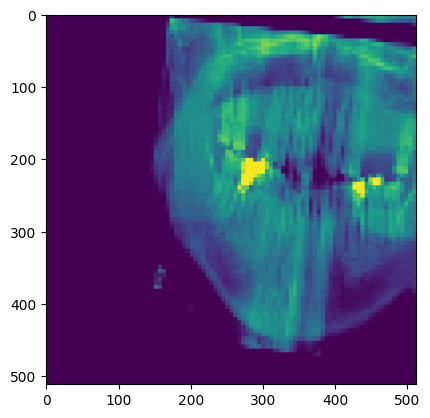

In [42]:
plt.imshow(rand_x)

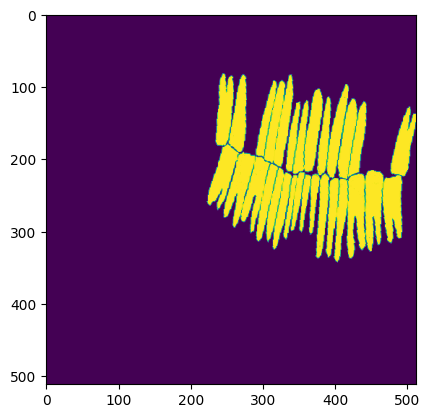

In [43]:
plt.imshow(rand_y)

In [44]:
import numpy as np
from glob import glob

from tensorflow import keras
from tensorflow.keras.layers import Input, Conv2D, Dropout, Activation, UpSampling2D, GlobalMaxPooling2D, multiply
from tensorflow.keras.backend import max

In [45]:
from keras_unet_collection import models, base, utils

name = 'unet3plus'
activation = 'ReLU'
filter_num_down = [32, 64, 128, 256, 512]
filter_num_skip = [32, 32, 32, 32]
filter_num_aggregate = 160

stack_num_down = 2
stack_num_up = 1
n_labels = 3

# `unet_3plus_2d_base` accepts an input tensor 
# and produces output tensors from different upsampling levels
# ---------------------------------------- #
input_tensor = keras.layers.Input((512, 512, 1))
# base architecture
X_decoder = base.unet_3plus_2d_base(
    input_tensor, filter_num_down, filter_num_skip, filter_num_aggregate, 
    stack_num_down=stack_num_down, stack_num_up=stack_num_up, activation=activation, 
    batch_norm=True, pool=True, unpool=True, backbone=None, name=name)

In [46]:
X_decoder

[<KerasTensor: shape=(None, 32, 32, 512) dtype=float32 (created by layer 'unet3plus_down4_conv_1_activation')>,
 <KerasTensor: shape=(None, 64, 64, 160) dtype=float32 (created by layer 'unet3plus_fusion_conv_0_0_activation')>,
 <KerasTensor: shape=(None, 128, 128, 160) dtype=float32 (created by layer 'unet3plus_fusion_conv_1_0_activation')>,
 <KerasTensor: shape=(None, 256, 256, 160) dtype=float32 (created by layer 'unet3plus_fusion_conv_2_0_activation')>,
 <KerasTensor: shape=(None, 512, 512, 160) dtype=float32 (created by layer 'unet3plus_fusion_conv_3_0_activation')>]

In [47]:
# allocating deep supervision tensors
OUT_stack = []
# reverse indexing `X_decoder`, so smaller tensors have larger list indices 
X_decoder = X_decoder[::-1]

# deep supervision outputs
for i in range(1, len(X_decoder)):
    # 3-by-3 conv2d --> upsampling --> sigmoid output activation
    pool_size = 2**(i)
    X = Conv2D(n_labels, 3, padding='same', name='{}_output_conv1_{}'.format(name, i-1))(X_decoder[i])
    
    X = UpSampling2D((pool_size, pool_size), interpolation='bilinear', 
                     name='{}_output_sup{}'.format(name, i-1))(X)
    
    X = Activation('sigmoid', name='{}_output_sup{}_activation'.format(name, i-1))(X)
    # collecting deep supervision tensors
    OUT_stack.append(X)

# the final output (without extra upsampling)
# 3-by-3 conv2d --> sigmoid output activation
X = Conv2D(n_labels, 3, padding='same', name='{}_output_final'.format(name))(X_decoder[0])
X = Activation('sigmoid', name='{}_output_final_activation'.format(name))(X)
# collecting final output tensors
OUT_stack.append(X)

In [48]:
OUT_stack

[<KerasTensor: shape=(None, 512, 512, 3) dtype=float32 (created by layer 'unet3plus_output_sup0_activation')>,
 <KerasTensor: shape=(None, 512, 512, 3) dtype=float32 (created by layer 'unet3plus_output_sup1_activation')>,
 <KerasTensor: shape=(None, 512, 512, 3) dtype=float32 (created by layer 'unet3plus_output_sup2_activation')>,
 <KerasTensor: shape=(None, 512, 512, 3) dtype=float32 (created by layer 'unet3plus_output_sup3_activation')>,
 <KerasTensor: shape=(None, 512, 512, 3) dtype=float32 (created by layer 'unet3plus_output_final_activation')>]

In [49]:
# Classification-guided Module (CGM)
# ---------------------------------------- #
# dropout --> 1-by-1 conv2d --> global-maxpooling --> sigmoid
X_CGM = X_decoder[-1]
X_CGM = Dropout(rate=0.1)(X_CGM)
X_CGM = Conv2D(filter_num_skip[-1], 1, padding='same')(X_CGM)
X_CGM = GlobalMaxPooling2D()(X_CGM)
X_CGM = Activation('sigmoid')(X_CGM)

CGM_mask = max(X_CGM, axis=-1) # <----- This value could be trained with "none-organ image"

for i in range(len(OUT_stack)):
    if i < len(OUT_stack)-1:
        # deep-supervision
        OUT_stack[i] = multiply([OUT_stack[i], CGM_mask], name='{}_output_sup{}_CGM'.format(name, i))
    else:
        # final output
        OUT_stack[i] = multiply([OUT_stack[i], CGM_mask], name='{}_output_final_CGM'.format(name))

In [50]:
OUT_stack

[<KerasTensor: shape=(None, 512, 512, 3) dtype=float32 (created by layer 'unet3plus_output_sup0_CGM')>,
 <KerasTensor: shape=(None, 512, 512, 3) dtype=float32 (created by layer 'unet3plus_output_sup1_CGM')>,
 <KerasTensor: shape=(None, 512, 512, 3) dtype=float32 (created by layer 'unet3plus_output_sup2_CGM')>,
 <KerasTensor: shape=(None, 512, 512, 3) dtype=float32 (created by layer 'unet3plus_output_sup3_CGM')>,
 <KerasTensor: shape=(None, 512, 512, 3) dtype=float32 (created by layer 'unet3plus_output_final_CGM')>]

In [51]:
# executing all the above cells in one time to avoid dupilcated tensor names.
unet3plus = keras.models.Model([input_tensor,], OUT_stack)

In [52]:
from keras_unet_collection import losses

def hybrid_loss(y_true, y_pred):

    loss_focal = losses.focal_tversky(y_true, y_pred, alpha=0.5, gamma=4/3)
    loss_iou = losses.iou_seg(y_true, y_pred)
    
    # (x) 
    #loss_ssim = losses.ms_ssim(y_true, y_pred, max_val=1.0, filter_size=4)
    
    return loss_focal+loss_iou #+loss_ssim

In [53]:
unet3plus.compile(loss=[hybrid_loss, hybrid_loss, hybrid_loss, hybrid_loss, hybrid_loss],
                  loss_weights=[0.25, 0.25, 0.25, 0.25, 1.0],
                  optimizer=keras.optimizers.Adam(learning_rate=1e-4))


In [54]:
unet3plus.fit(x_train,y_train,batch_size=100,epochs=10,verbose=1)

Epoch 1/10


ResourceExhaustedError: Graph execution error:

SameWorkerRecvDone unable to allocate output tensor. Key: /job:localhost/replica:0/task:0/device:CPU:0;e7d67e2ac5985081;/job:localhost/replica:0/task:0/device:GPU:0;edge_171_IteratorGetNext;0:0
	 [[{{node IteratorGetNext/_2}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.
 [Op:__inference_train_function_11518]

Tới đây thì coi như xử lý ảnh đã xong
Size hình: IMAGE_SIZE
Dữ liệu để train: x_train
Mask của train: y_train


In [ ]:
# Hàm để lưu model sau khi train
from datetime import datetime
def model_save(model):
    now = datetime.now()
    model_name = f"model_trained_{now.strftime('%d-%m-%Y+%H-%M-%S')}"
    model.save(f"{model_name}.h5")

In [ ]:
# Xây mô hình ở đây
from model import *
input_shape = (*IMAGE_SIZE, 1)
model=UNET(input_shape=input_shape, last_activation='sigmoid')
model.summary()

In [ ]:
#Complie for model
model.compile(optimizer ='adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

In [ ]:

#Train model
#Your choice batch and epoch
model.fit(x_train, y_train, batch_size=8, epochs=200, verbose=1)


In [ ]:
# Load model ra để dùng
from keras.models import load_model
model_path = "model_trained_17-08-2022+08-26-38.h5"
model = load_model(model_path)

In [ ]:
y_test_predict = model.predict(x_test)

In [ ]:
# Lưu ảnh gốc với tấm ảnh nó dự đoán, với tấm ảnh mong đợi nó ra
for i, predict in enumerate(y_test_predict):
    
    folder = PREDICT_FOLDER + f"{i}/"
    if not os.path.exists(folder): os.mkdir(folder)
    for f in os.listdir(folder): os.remove(folder + f)
    
    cv2.imwrite(PREDICT_FOLDER + f"{i}/{i}_x_test.png", np.uint8(x_test[i] * 255))
    cv2.imwrite(PREDICT_FOLDER + f"{i}/{i}_y_predict.png", np.uint8(predict * 255))
    cv2.imwrite(PREDICT_FOLDER + f"{i}/{i}_y_expected.png", np.uint8(y_test_expected[i] * 255))

In [ ]:
# Phân đoạn dựa trên ảnh đầu vào, ảnh predict
from CCA_Analysis import *

original_x_test = os.listdir(INPUT_TESTING_FOLDER)

for i, x_test_name in enumerate(original_x_test):

    img = cv2.imread(INPUT_TESTING_FOLDER + x_test_name)
    plt.imsave(PREDICT_FOLDER + f"{i}/{i}_x_test_original.png", img)

    shape = (img.shape[1], img.shape[0])

    predict = cv2.imread(PREDICT_FOLDER + f"{i}/{i}_y_predict.png")
    predict = cv2.resize(predict, shape, interpolation=cv2.INTER_LANCZOS4)

    cca_predict, teeth_count = CCA_Analysis(img, predict, 3, 2)
    plt.imsave(PREDICT_FOLDER + f"{i}/{i}_y_test_predict_original.png", predict)
    plt.imsave(PREDICT_FOLDER + f"{i}/{i}_cca+teeth_count_{teeth_count}.png", cca_predict)
    